In [3]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import time
from scipy.interpolate import RegularGridInterpolator
# Set up paths for utility imports
current_dir = os.getcwd()
utilities_dir = os.path.join(current_dir, '../../utils')

# Change working directory
os.chdir(current_dir)
sys.path.insert(0, utilities_dir)

from plotting import *  

In [10]:
 

# ==========================================================
# 2D Problem:
#     ∇²f = -(5π)² sin(5πx) sin(5πy)
#     f = 0 on the boundaries
# Analytical solution: f(x,y) = sin(5πx) sin(5πy)
# ==========================================================

def f_exact(x, y):
    return np.sin(4 * np.pi * x) * np.sin(4 * np.pi * y)

def rhs(x, y):
    return -2 * (4 * np.pi)**2 * np.sin(4 * np.pi * x) * np.sin(4 * np.pi * y)

# General parameters
N_values = list(range(10, 51, 5))  # total points per axis (including boundaries)
relative_errors = []
times = []
results = {}
n_runs = 1

# ==========================================================
# Compute numerical solutions, errors, and timings
# ==========================================================
for N in N_values:
    x = np.linspace(0, 1, N)
    y = np.linspace(0, 1, N)
    X, Y = np.meshgrid(x, y, indexing='ij')
    h = x[1] - x[0]
    n = N * N

    # Apply Dirichlet BCs: zero at boundaries
    mask_inner = np.ones((N, N), dtype=bool)
    mask_inner[0, :] = mask_inner[-1, :] = False
    mask_inner[:, 0] = mask_inner[:, -1] = False
    inner_indices = np.argwhere(mask_inner)
    n_int = inner_indices.shape[0]

    run_times = []
    for _ in range(n_runs):
        start = time.time()

        # Build matrix for interior points only
        A = np.zeros((n_int, n_int))
        index_map = -np.ones((N, N), dtype=int)
        for k, (i, j) in enumerate(inner_indices):
            index_map[i, j] = k

        for k, (i, j) in enumerate(inner_indices):
            A[k, k] = -4
            for di, dj in [(-1,0), (1,0), (0,-1), (0,1)]:
                ni, nj = i + di, j + dj
                if index_map[ni, nj] != -1:
                    A[k, index_map[ni, nj]] = 1

        A /= h**2
        b = rhs(X[mask_inner], Y[mask_inner])
        f_int = np.linalg.solve(A, b)
        run_times.append(time.time() - start)

    elapsed_mean = np.mean(run_times)

    # Reconstruct full field
    f_total = np.zeros_like(X)
    f_total[mask_inner] = f_int
    f_exact_total = f_exact(X, Y)

    rel_error = np.max(np.abs(f_total - f_exact_total)) / np.max(np.abs(f_exact_total))
    relative_errors.append(rel_error)
    times.append(elapsed_mean)
    results[N] = (X, Y, f_total)
 


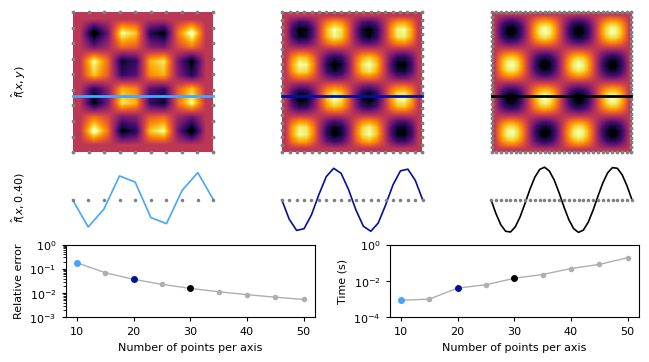

In [17]:
# ==========================================================
# Compact Figure Layout with Labels on Left
# ==========================================================
fig = plt.figure(figsize=(7.4, 4.0))
outer_gs = GridSpec(3, 1, height_ratios=[0.8, 0.8, 0.4], figure=fig, hspace=-0.23)

colors = ['#45A5FF', "#0010A1", "#000000"]
N_examples = [10, 20, 30]
plt.subplots_adjust(hspace=-2.9, wspace=0.0)

# === Row 1: 2D contours ===
gs_top = outer_gs[0].subgridspec(1, 3, wspace=0.35)
for i, (N, color) in enumerate(zip(N_examples, colors)):
    ax = fig.add_subplot(gs_top[0, i])
    X, Y, F = results[N]
    cf = ax.imshow(
        F.T,
        extent=(0, 1, 0, 1),
        cmap="inferno",
        vmin=-1,
        vmax=1,
        interpolation="bilinear",
        origin="lower",
    )
    border_mask = (X == 0) | (X == 1) | (Y == 0) | (Y == 1)
    ax.scatter(X[border_mask], Y[border_mask], color="tab:gray", s=3, zorder=2)

    y_line = 0.40
    ax.plot(X[:, 0], np.full_like(X[:, 0], y_line), color=color, lw=2, zorder=3)

    ax.set_xlim(-0.02, 1.02)
    ax.set_ylim(-0.02, 1.02)
    ax.set_aspect("equal", adjustable="box")
    ax.axis("off")

# Añadir anotación a la izquierda de la primera fila
fig.text(0.05, 0.70, r"$\hat{f}(x,y)$", fontsize=8, va="center", ha="left", rotation=90)

# === Row 2: 1D slices ===
gs_mid = outer_gs[1].subgridspec(1, 3, wspace=0.35)
for i, (N, color) in enumerate(zip(N_examples, colors)):
    ax = fig.add_subplot(gs_mid[0, i])
    X, Y, F = results[N]
    idx_mid = np.argmin(np.abs(Y[0, :] - 0.40))
    ax.plot(X[:, idx_mid], F[:, idx_mid], '-', color=color, lw=1.2)
    ax.plot(X[:, idx_mid], np.zeros_like(X[:, idx_mid]), '.', color='tab:gray', markersize=3)
    ax.set_ylim(-2.0, 2.0)
    ax.axis('off')

# Añadir anotación a la izquierda de la segunda fila
fig.text(0.05, 0.41, r"$\hat{f}(x,0.40)$", fontsize=8, va="center", ha="left", rotation=90)

plt.subplots_adjust(hspace=-0.3, wspace=0.0)

# === Row 3: Error and time ===
gs_bottom = outer_gs[2].subgridspec(1, 2, wspace=0.30)
ax_errN = fig.add_subplot(gs_bottom[0, 0])
ax_errT = fig.add_subplot(gs_bottom[0, 1])

ax_errN.plot(N_values, relative_errors, '.-', lw=1, color='#AFAFAF')
for N, color in zip(N_examples, colors):
    idx = N_values.index(N)
    ax_errN.plot(N_values[idx], relative_errors[idx], '.', color=color, markersize=8)
ax_errN.set_xlabel('Number of points per axis')
ax_errN.set_ylabel('Relative error')
ax_errN.set_yscale('log')
ax_errN.set_ylim(top=1e0, bottom=1e-3)

ax_errT.plot(N_values, times, '.-', lw=1, color='#AFAFAF')
for N, color in zip(N_examples, colors):
    idx = N_values.index(N)
    ax_errT.plot(N_values[idx], times[idx], '.', color=color, markersize=8)
ax_errT.set_xlabel('Number of points per axis')
ax_errT.set_ylabel('Time (s)')
ax_errT.set_yscale('log')
ax_errT.set_ylim(top=1e0, bottom=1e-4)

plt.savefig("figs/helmholtz2D_convergence.svg", dpi=150, bbox_inches='tight')
plt.savefig("figs/helmholtz2D_convergence.pdf", dpi=150, bbox_inches='tight')
plt.show()
